Analyse some recent GOLEM shots from 25000 to 26023. 

# Getting data

The dataset has been created from the [GolSQL tool](http://golem.fjfi.cvut.cz/utils/miner), with the follow URL used to generate the dataset:


http://golem.fjfi.cvut.cz/utils/miner?new_diagn=input_power_plasma_mean&action=Add&xaxis=ShotNo&start_shot=21000&end_shot=29162&diagn_0=breakdown_field&filter_0=none&subplot_0=&yrange0_0=&yrange1_0=&scale_0=linear&diagn_1=breakdown_probability&filter_1=none&subplot_1=&yrange0_1=&yrange1_1=&scale_1=linear&diagn_2=breakdown_rate&filter_2=none&subplot_2=&yrange0_2=&yrange1_2=&scale_2=linear&diagn_3=breakdown_rate_err&filter_3=none&subplot_3=&yrange0_3=&yrange1_3=&scale_3=linear&diagn_4=breakdown_time&filter_4=none&subplot_4=&yrange0_4=&yrange1_4=&scale_4=linear&diagn_5=breakdown_voltage&filter_5=none&subplot_5=&yrange0_5=&yrange1_5=&scale_5=linear&diagn_6=cb&filter_6=none&subplot_6=&yrange0_6=&yrange1_6=&scale_6=linear&diagn_7=cbd&filter_7=none&subplot_7=&yrange0_7=&yrange1_7=&scale_7=linear&diagn_8=ccd&filter_8=none&subplot_8=&yrange0_8=&yrange1_8=&scale_8=linear&diagn_9=cst&filter_9=none&subplot_9=&yrange0_9=&yrange1_9=&scale_9=linear&diagn_10=chamber_inductance&filter_10=none&subplot_10=&yrange0_10=&yrange1_10=&scale_10=linear&diagn_11=chamber_resistance&filter_11=none&subplot_11=&yrange0_11=&yrange1_11=&scale_11=linear&diagn_12=chamber_temperature&filter_12=none&subplot_12=&yrange0_12=&yrange1_12=&scale_12=linear&diagn_13=discharge_aborted&filter_13=none&subplot_13=&yrange0_13=&yrange1_13=&scale_13=linear&diagn_14=electron_confinement_t98&filter_14=none&subplot_14=&yrange0_14=&yrange1_14=&scale_14=linear&diagn_15=electron_confinement_time&filter_15=none&subplot_15=&yrange0_15=&yrange1_15=&scale_15=linear&diagn_16=electron_temperature_max&filter_16=none&subplot_16=&yrange0_16=&yrange1_16=&scale_16=linear&diagn_17=lb&filter_17=none&subplot_17=&yrange0_17=&yrange1_17=&scale_17=linear&diagn_18=loop_voltage_max&filter_18=none&subplot_18=&yrange0_18=&yrange1_18=&scale_18=linear&diagn_19=loop_voltage_mean&filter_19=none&subplot_19=&yrange0_19=&yrange1_19=&scale_19=linear&diagn_20=plasma&filter_20=none&subplot_20=&yrange0_20=&yrange1_20=&scale_20=linear&diagn_21=plasma_life&filter_21=none&subplot_21=&yrange0_21=&yrange1_21=&scale_21=linear&diagn_22=toroidal_field_mean&filter_22=none&subplot_22=&yrange0_22=&yrange1_22=&scale_22=linear&diagn_23=toroidal_field_max&filter_23=none&subplot_23=&yrange0_23=&yrange1_23=&scale_23=linear&diagn_24=ub&filter_24=none&subplot_24=&yrange0_24=&yrange1_24=&scale_24=linear&diagn_25=ubd&filter_25=none&subplot_25=&yrange0_25=&yrange1_25=&scale_25=linear&diagn_26=ucd&filter_26=none&subplot_26=&yrange0_26=&yrange1_26=&scale_26=linear&diagn_27=ust&filter_27=none&subplot_27=&yrange0_27=&yrange1_27=&scale_27=linear&diagn_28=tst&filter_28=none&subplot_28=&yrange0_28=&yrange1_28=&scale_28=linear&diagn_29=tcd&filter_29=none&subplot_29=&yrange0_29=&yrange1_29=&scale_29=linear&diagn_30=tb&filter_30=none&subplot_30=&yrange0_30=&yrange1_30=&scale_30=linear&diagn_31=tbd&filter_31=none&subplot_31=&yrange0_31=&yrange1_31=&scale_31=linear&diagn_32=pressure&filter_32=none&subplot_32=&yrange0_32=&yrange1_32=&scale_32=linear&diagn_33=pressure_chamber&filter_33=none&subplot_33=&yrange0_33=&yrange1_33=&scale_33=linear&diagn_34=pressure_initial&filter_34=none&subplot_34=&yrange0_34=&yrange1_34=&scale_34=linear&diagn_35=pressure_request&filter_35=none&subplot_35=&yrange0_35=&yrange1_35=&scale_35=linear&diagn_36=plasma_current_mean&filter_36=none&subplot_36=&yrange0_36=&yrange1_36=&scale_36=linear&diagn_37=plasma_current_decay&filter_37=none&subplot_37=&yrange0_37=&yrange1_37=&scale_37=linear&diagn_38=zeff&filter_38=none&subplot_38=&yrange0_38=&yrange1_38=&scale_38=linear&diagn_39=input_power_mean&filter_39=none&subplot_39=&yrange0_39=&yrange1_39=&scale_39=linear

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import numpy as np

In [52]:
dataset = pd.read_csv('close_shots.txt', delimiter='\s+', index_col='shots')

In [53]:
dataset.head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,input_power_mean,breakdown_voltage,...,breakdown_rate_err,ubd,plasma_current_mean,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
21000,0.25301,0.0036,0.0675,0.060770,0.005,33.988,400.0,0.005,17840.0,10.0240,...,NaN,0.0,2437.8,90.0,NaN,NaN,7.3181,0.0135,19.694,800.0
21001,0.25693,0.0036,0.0675,0.059614,0.005,35.284,400.0,0.005,17730.0,9.7620,...,NaN,0.0,2454.3,90.0,NaN,NaN,7.2241,0.0135,19.449,800.0
21002,0.25301,0.0036,0.0675,0.060246,0.005,35.229,400.0,0.005,17943.0,9.8627,...,NaN,0.0,2523.7,90.0,NaN,NaN,7.1100,0.0135,19.878,800.0
21003,0.24821,0.0036,0.0675,0.059842,0.005,34.959,400.0,0.005,18023.0,9.8761,...,NaN,0.0,2478.7,90.0,NaN,NaN,7.2711,0.0135,19.850,800.0
21004,0.24821,0.0036,0.0675,0.060699,0.005,36.230,400.0,0.005,17515.0,9.6344,...,NaN,0.0,2523.1,90.0,NaN,NaN,6.9421,0.0135,19.629,800.0


# Cleaning data

Filter bad shots from the dataset, as adviced in the [GOLEM DataMining Page](http://golem.fjfi.cvut.cz/wiki/Handling/DataMining/data_mining)

In [54]:
print(len(dataset)) # number of shot before cleaning 

8141


In [55]:
# Drop failed plasma
dataset = dataset.dropna(subset=['plasma'])

# Drop plasma longer than 25 ms
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# Drop negative pressure request
dataset = dataset.drop(dataset[dataset['pressure_request'] < 0].index)

# Drop non physical ucd values
dataset = dataset.drop(dataset[dataset['ucd'] < 200].index)

# number of shot after cleaning
print(len(dataset)) 

7203


# Confinement Time Evolution

In [56]:
dataset.columns

Index(['pressure_initial', 'cbd', 'cb', 'breakdown_field', 'tb',
       'electron_temperature_max', 'ucd', 'tcd', 'input_power_mean',
       'breakdown_voltage', 'plasma_life', 'breakdown_time', 'lb', 'ust',
       'plasma_current_decay', 'cst', 'tst', 'plasma',
       'electron_confinement_time', 'chamber_temperature', 'breakdown_rate',
       'pressure_request', 'electron_confinement_t98', 'zeff',
       'toroidal_field_mean', 'chamber_resistance', 'pressure',
       'chamber_inductance', 'toroidal_field_max', 'tbd',
       'input_power_plasma_mean', 'breakdown_rate_err', 'ubd',
       'plasma_current_mean', 'breakdown_probability', 'discharge_aborted',
       'pressure_chamber', 'loop_voltage_mean', 'ccd', 'loop_voltage_max',
       'ub'],
      dtype='object')

(1e-06, 0.001)

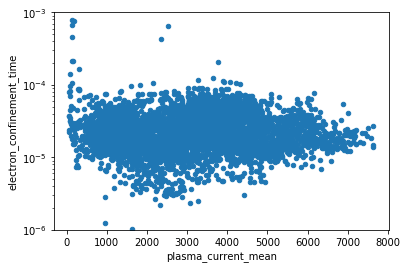

In [57]:
ax=dataset.plot(x='plasma_current_mean', y='electron_confinement_time', kind='scatter', logy=True)
ax.set_ylim(1e-6, 1e-3)

It is not clear if the confinement time directly depends of the plasma current in GOLEM. The plasma being resistive, this scaling law probably doesn't apply in this case.

Now we test if the confinement time depends of the density. A proxy for the density is the pressure, if we suppose that most of the injected gaz is ionized.

(0, 80)

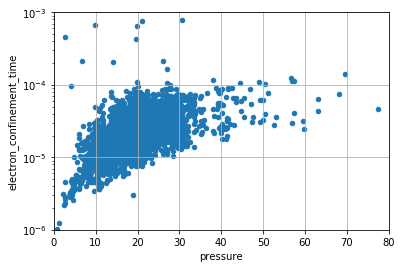

In [58]:
ax=dataset.plot(x='pressure', y='electron_confinement_time', kind='scatter', logy=True, grid=True)
ax.set_ylim(1e-6, 1e-3)
ax.set_xlim(0, 80)

Now let's see if as expected, increasing the plasma current increases the electron temperature 

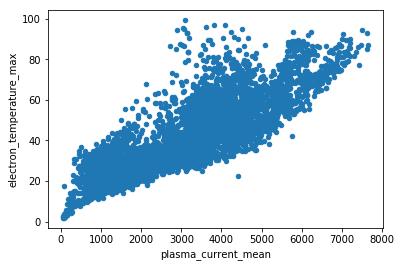

In [59]:
dataset.plot(x='plasma_current_mean', y='electron_temperature_max', kind='scatter')

## Which parameters to maximize the plasma current?

In [60]:
# get the longest shots
dataset_ip = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_current_mean', 'input_power_mean']].dropna()
# keep only the pressure request=20 (majority) to remove a dimension
dataset_ip = dataset_ip[dataset_ip['pressure_request'] == 20]
# keep only the tcd=600 µs (majority) to remove a dimension
dataset_ip = dataset_ip[dataset_ip['tcd'] == 0.006]
dataset_ip = dataset_ip.drop(['tcd','pressure_request'], axis=1)

dataset_ip.sort_values('plasma_current_mean', ascending=False).head()


,ub,ucd,plasma_current_mean,input_power_mean
shots,,,,
25954,1100.0,600.0,6591.1,41242.0
26950,1100.0,700.0,6404.1,56153.0
26948,1200.0,700.0,6350.4,55554.0
23593,1100.0,650.0,6147.4,47340.0
26498,1100.0,500.0,6019.2,31522.0


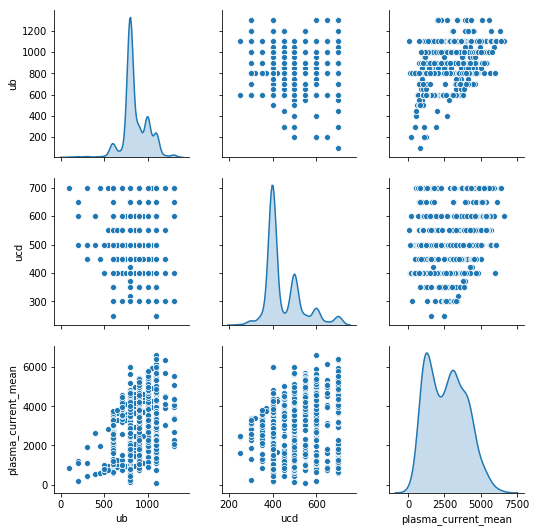

In [61]:
seaborn.pairplot(dataset_ip[['ub', 'ucd','plasma_current_mean']], diag_kind='kde')

In [62]:
# make the average of similar parameters
dataset_ip_avg = dataset_ip.groupby(['ucd','ub']).mean().reset_index()
dataset_ip_avg.head(10)

,ucd,ub,plasma_current_mean,input_power_mean
0,250.0,600.0,1600.900,8415.600000
1,250.0,1100.0,2463.750,9222.000000
2,300.0,600.0,1582.550,7929.750000
3,300.0,700.0,2567.600,13687.000000
4,300.0,800.0,2322.845,10918.875000
5,300.0,900.0,2769.100,10058.000000
6,300.0,1000.0,2348.400,11470.666667
7,300.0,1100.0,2912.530,12039.500000
8,300.0,1200.0,3040.200,12066.666667
9,300.0,1300.0,3368.200,13176.000000


Text(0.5, 1.0, 'Plasma current (mean)')

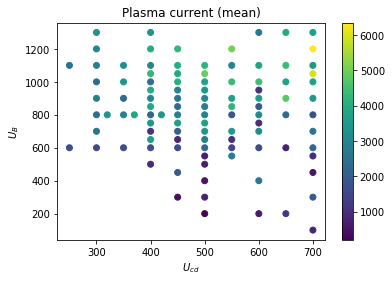

In [63]:
fig, ax = plt.subplots()
cax1=ax.scatter(x=dataset_ip_avg['ucd'], y=dataset_ip_avg['ub'], c=dataset_ip_avg['plasma_current_mean'])
cb1=plt.colorbar(cax1)
ax.set_xlabel('$U_{cd}$')
ax.set_ylabel('$U_B$')
ax.set_title('Plasma current (mean)')

# Which parameters to improve the plasma lifetime?

In [64]:
# get the longest shots
dataset_lt = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_life']].dropna()
dataset_lt.sort_values('plasma_life', ascending=False).head()

,ub,ucd,tcd,pressure_request,plasma_life
shots,,,,,
25341,1300.0,400.0,0.005,20,0.02498
23800,1300.0,400.0,0.005,20,0.02498
24292,1300.0,450.0,0.005,20,0.02494
25483,1300.0,400.0,0.005,20,0.02494
25479,1300.0,400.0,0.005,20,0.02486


According to the GOLEM documentation, the following parameters can be tuned for each plasma shot:

 - Toroidal Magnetic Field, set by $U_B$
 - Current Drive, set bu $U_{CD}$
 - Time delay for Current Drive, $\tau_{CD}$
 - Filling Pressure, $p_{WG}$ [mPa]
 
So let's look for the set of parameters which maximize the plasma duration

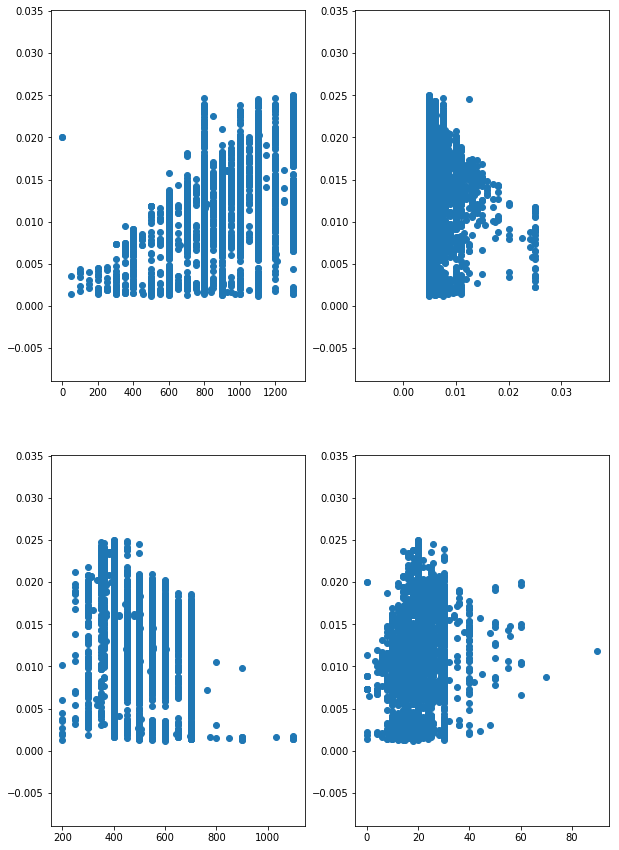

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(10,15))
ax[0,0].scatter(dataset_lt['ub'], dataset_lt['plasma_life'])
ax[1,0].scatter(dataset_lt['ucd'], dataset_lt['plasma_life'])
ax[0,1].scatter(dataset_lt['tcd'], dataset_lt['plasma_life'])
ax[1,1].scatter(dataset_lt['pressure_request'], dataset_lt['plasma_life'])

The question is : what is the set of parameters $\{u_B, u_{CD}, \tau_{CD}, p\}$ which maximize the plasma duration ? 

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


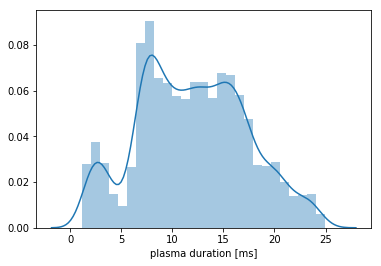

In [74]:
seaborn.distplot(dataset_lt['plasma_life']*1e3, axlabel='plasma duration [ms]')

So, how to produce a plasma duration larger than 15 ms ?

In [75]:
longest_shots = dataset_lt[dataset_lt['plasma_life'] > 15e-3]

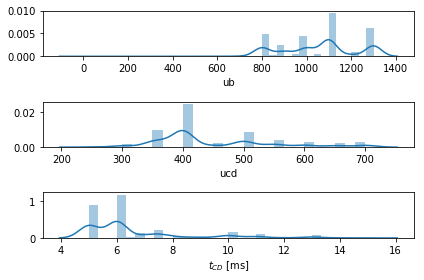

In [76]:
fig, ax = plt.subplots(3,1)
seaborn.distplot(longest_shots['ub'], ax=ax[0])
seaborn.distplot(longest_shots['ucd'], ax=ax[1])
seaborn.distplot(longest_shots['tcd']*1e3, ax=ax[2], axlabel='$t_{CD}$ [ms]')
fig.tight_layout()

The longuest shots are the ones using high $U_B$ (1100), $U_{cd}$ close to 400 and $t_{cd}$ around 5-6 ms.

In [69]:
# make the average of similar parameters
dataset_pl_avg = dataset.groupby(['ucd','ub','tcd']).mean().reset_index()
dataset_pl_avg.head(10)

,ucd,ub,tcd,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,input_power_mean,...,input_power_plasma_mean,breakdown_rate_err,ubd,plasma_current_mean,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max
0,200.0,0.0,0.0060,0.103850,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,0.0135,5.525500
1,200.0,100.0,0.0060,0.154210,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,0.0135,6.308300
2,200.0,150.0,0.0065,0.711935,0.0036,0.0675,0.032025,0.005,11.499750,1331.165000,...,1175.060000,NaN,0.0,235.125000,15.000000,NaN,NaN,5.7538,0.0135,8.509850
3,200.0,200.0,0.0050,0.457861,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,6.187500,NaN,NaN,NaN,0.0135,6.116744
4,200.0,200.0,0.0060,0.153475,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,1.500000,NaN,NaN,NaN,0.0135,6.535950
5,200.0,200.0,0.0070,0.257030,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,11.000000,NaN,NaN,NaN,0.0135,6.606400
6,200.0,200.0,0.0100,0.738970,0.0036,0.0675,0.065472,0.005,25.436333,2788.066667,...,2004.700000,NaN,0.0,668.673333,9.666667,NaN,NaN,4.1693,0.0135,7.855633
7,200.0,400.0,0.0115,0.232530,0.0036,0.0675,NaN,0.005,NaN,NaN,...,NaN,NaN,0.0,NaN,22.000000,NaN,NaN,NaN,0.0135,6.478900
8,200.0,500.0,0.0070,0.564350,0.0036,0.0675,-0.088962,0.005,30.522000,25226.000000,...,22060.000000,NaN,0.0,2825.100000,0.000000,NaN,NaN,8.9294,0.0135,25.983000
9,200.0,600.0,0.0050,0.855246,0.0036,0.0675,0.080828,0.005,7.923700,1367.453333,...,1146.986667,NaN,0.0,264.721000,25.400000,NaN,NaN,5.8209,0.0135,7.316800


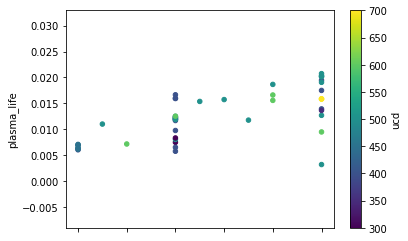

In [70]:
dataset[(dataset['tcd'] == 0.006)&(dataset['pressure_request'] == 26)].plot(x='ub', y='plasma_life', kind='scatter', c='ucd', colormap='viridis')

## GOLEM Most frequent set of parameters

In [78]:
# get the number of occurence of unique rows, 
# ie the most frequent set of parameters used on GOLEM
dataset.groupby(['ucd', 'tcd','ub','pressure_request']).size().reset_index(name='count').sort_values('count', ascending=False).head()

,ucd,tcd,ub,pressure_request,count
403,400.0,0.006,800.0,20,801
353,400.0,0.005,1300.0,20,135
436,400.0,0.006,1000.0,20,134
937,500.0,0.006,800.0,20,123
333,400.0,0.005,1100.0,20,115


Most parameter set are $U_{cd}=400$, $t_{cd}=0.006$, $U_B=800$ and a pressure request of 20. 